In [1]:
import pandas as pd
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('dataset.csv', encoding='utf-8')
df.columns.to_list()

['Customer_ID',
 'Customer_Name',
 'Gender',
 'Age',
 'City',
 'Bank_Name',
 'Account_Type',
 'Transaction_ID',
 'Transaction_Date',
 'Transaction_Time',
 'Transaction_Amount',
 'Merchant_ID',
 'Transaction_Type',
 'Merchant_Category',
 'Account_Balance',
 'Transaction_Device',
 'Transaction_Scope',
 'Transaction_Currency',
 'Customer_Contact',
 'Transaction_Description',
 'Customer_Email',
 'Is_Fraud']

In [3]:
# Convert the trans time into categorical data (Night, day, etc)
# timestamp and hour are helper cols only
df['timestamp'] = pd.to_datetime(df['Transaction_Time'], format='%H:%M:%S')
df['hour'] = df['timestamp'].dt.hour

def categorize_time(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Noon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['time_period'] = df['hour'].apply(categorize_time)

# Convert to numerical for your model
df = pd.get_dummies(df, columns=['time_period'])

In [4]:
df_clean = df.drop(
    columns=[
        # 'Customer_ID', 
        'Customer_Name', 
        'Transaction_ID', 
        'Merchant_ID', 
        'Customer_Contact', 
        'Customer_Email', 
        'Transaction_Description',
        'Transaction_Date', 
        'Transaction_Time',
        'Bank_Name',
        'City',
        'Gender'
    ],
    errors='ignore' 
)

In [5]:
def bankrupt_ratio(df):
    # add 0.01 to avoid dividing to 0
    df['amount_to_balance_ratio'] = df['Transaction_Amount'] / (df['Account_Balance'] + 0.01)
    return df

bankrupt_ratio(df_clean)
# print(df_clean.head())
# df_clean.columns.to_list()

def high_amount_night(df):
    # 1. Define "Night" (Hours < 5 AM or > 9 PM)
    is_night = (df['time_period_Night'] == True)
    
    # 2. Define "High Amount" (e.g., Top 10% of all transactions)
    # We calculate the 90th percentile dynamically
    high_threshold = df['Transaction_Amount'].quantile(0.90)
    is_high_amount = df['Transaction_Amount'] > high_threshold

    # 3. Combine: If BOTH are True, return 1. Else 0.
    df['high_amount_night'] = (is_night & is_high_amount).astype(int)
    return df

high_amount_night(df_clean)

def velocity_check(df):
    # 1. Ensure timestamp is datetime (just in case)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # 2. Sort is MANDATORY for rolling time windows
    df = df.sort_values(['Customer_ID', 'timestamp'])

    # 3. Calculate Velocity using an index-based approach
    # We set the index to timestamp so rolling('24h') knows what to measure
    df['velocity_24h'] = (
        df.set_index('timestamp')
          .groupby('Customer_ID')
          ['Transaction_Amount'] # We can count any column
          .rolling('24h')
          .count()
          .reset_index(level=0, drop=True) # Remove the Customer_ID index level
          .values # Extract the raw numbers to put back in the original df
    )
    
    df['velocity_6h'] = (
        df.set_index('timestamp')
          .groupby('Customer_ID')
          ['Transaction_Amount']
          .rolling('6h')
          .count()
          .reset_index(level=0, drop=True)
          .values
    )
    
    return df

# Apply the fix
df_clean = velocity_check(df_clean)

def savings_attack(df):
    # Logic: Is it a Savings account AND has a high 6h velocity?
    # We use 2 as the threshold as per your project plan
    df['is_savings_attack'] = (
        (df['Account_Type'] == 'Savings') & 
        (df['velocity_6h'] >= 2)
    ).astype(int)
    
    return df

savings_attack(df_clean)

,Customer_ID,Age,Account_Type,Transaction_Amount,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Scope,Transaction_Currency,...,hour,time_period_Evening,time_period_Morning,time_period_Night,time_period_Noon,amount_to_balance_ratio,high_amount_night,velocity_24h,velocity_6h,is_savings_attack
176176,00000d7b-73b6-432c-a706-62447bc30275,63,Business,19043000.00,Debit,Entertainment,8.468540e+08,Self-service Banking Machine,Domestic,VND,...,21,False,False,True,False,0.022487,1,1.0,1.0,0
35261,00009fec-323d-4d5d-8919-25be9fb648bd,34,Business,19694000.00,Debit,Electronics,8.954320e+08,POS Mobile App,Domestic,VND,...,4,False,False,True,False,0.021994,1,1.0,1.0,0
75748,000122d9-0442-44a7-9c6a-ec6d8a7135a5,42,Savings,17135000.00,Bill Payment,Groceries,1.269100e+08,Tablet,Domestic,VND,...,3,False,False,True,False,0.135017,0,1.0,1.0,0
145661,00014b31-64db-4fa5-af94-96c6c80f6a80,68,Business,1150000.00,Bill Payment,Groceries,3.352100e+07,POS Terminal,Domestic,VND,...,19,True,False,False,False,0.034307,0,1.0,1.0,0
76866,0001ff91-234e-497a-bd2d-c650c14b8d13,56,Checking,5916000.00,Bill Payment,Health,1.714730e+08,Tablet,Domestic,VND,...,3,False,False,True,False,0.034501,0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105119,fffd6c3d-a2c0-4faf-9f5b-39ccd82edb7c,24,Savings,1581.79,Transfer,Entertainment,6.519483e+04,Web Browser,Domestic,USD,...,0,False,False,True,False,0.024263,0,1.0,1.0,0
61408,fffde4d0-0577-44d3-8a30-7068bce0811a,51,Savings,1665.17,Credit,Clothing,6.807914e+04,Bank Branch,International,USD,...,23,False,False,True,False,0.024459,0,1.0,1.0,0
4746,fffe5c27-a610-486b-82b3-446cd60645f3,21,Savings,6228000.00,Credit,Electronics,2.542670e+08,Wearable Device,Domestic,VND,...,14,False,False,False,True,0.024494,0,1.0,1.0,0
17483,fffe8243-2b3e-41a4-b51c-ee69249520b7,65,Checking,7451000.00,Bill Payment,Clothing,2.945830e+08,POS Terminal,Domestic,VND,...,2,False,False,True,False,0.025293,0,1.0,1.0,0


In [6]:
# Final clean
df_clean = df_clean.drop(
    columns=[
        'Customer_ID',
        'timestamp'
    ], 
    errors="ignore"
)

# MOVE 'Is_Fraud' TO THE END
# Create a list of all columns except 'Is_Fraud'
cols = [col for col in df_clean.columns if col != 'Is_Fraud']

# Append 'Is_Fraud' to the end of that list
cols.append('Is_Fraud')

# Reorder the dataframe
df_clean = df_clean[cols]

df_clean.columns.to_list()

['Age',
 'Account_Type',
 'Transaction_Amount',
 'Transaction_Type',
 'Merchant_Category',
 'Account_Balance',
 'Transaction_Device',
 'Transaction_Scope',
 'Transaction_Currency',
 'hour',
 'time_period_Evening',
 'time_period_Morning',
 'time_period_Night',
 'time_period_Noon',
 'amount_to_balance_ratio',
 'high_amount_night',
 'velocity_24h',
 'velocity_6h',
 'is_savings_attack',
 'Is_Fraud']

In [7]:
keep_cols = ['Transaction_Amount', 'Account_Balance', 'amount_to_balance_ratio', 'velocity_6h', 'velocity_24h', 'is_savings_attack', 'Is_Fraud']

df_clean = df_clean[keep_cols]

df_clean.columns.to_list()


['Transaction_Amount',
 'Account_Balance',
 'amount_to_balance_ratio',
 'velocity_6h',
 'velocity_24h',
 'is_savings_attack',
 'Is_Fraud']

In [ ]:
# Seperate the Features and the Target
X = df_clean.iloc[:, 0:-1]
y = df_clean.iloc[:, -1]    # The isFraud col

# Now split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)

smote = SMOTE(k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled = X_resampled.round().astype(int)   # To avoid synthetic value being float like 1.5

rf = RandomForestClassifier(
    n_estimators=200,          # Increase number of trees
    class_weight={0: 1, 1: 25}, # Manually set higher weight for Fraud
    max_depth=None,            # Let the trees grow deeper to find complex rules
    min_samples_leaf=2,        # More specific rules
    n_jobs=-1,
)
rf.fit(X_resampled, y_resampled)    # Training part
joblib.dump(rf, "rfFeaturePruning.joblib") # Save for later use - when test on actual data

['rfFeaturePruning.joblib']

0.606875
              precision    recall  f1-score   support

           0      0.948     0.620     0.750     37983
           1      0.048     0.364     0.085      2017

    accuracy                          0.607     40000
   macro avg      0.498     0.492     0.418     40000
weighted avg      0.903     0.607     0.716     40000



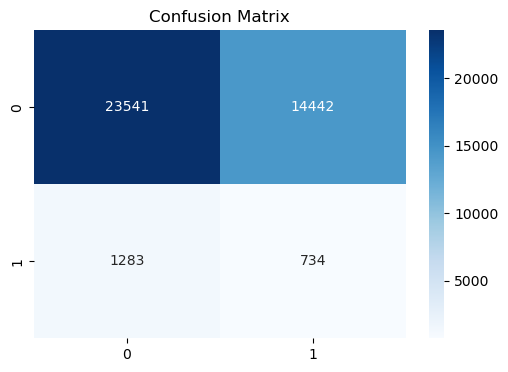

In [9]:
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)  
print(score)
print(classification_report(y_test, y_pred, digits=3))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_18052\1085187201.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(25), palette='viridis')


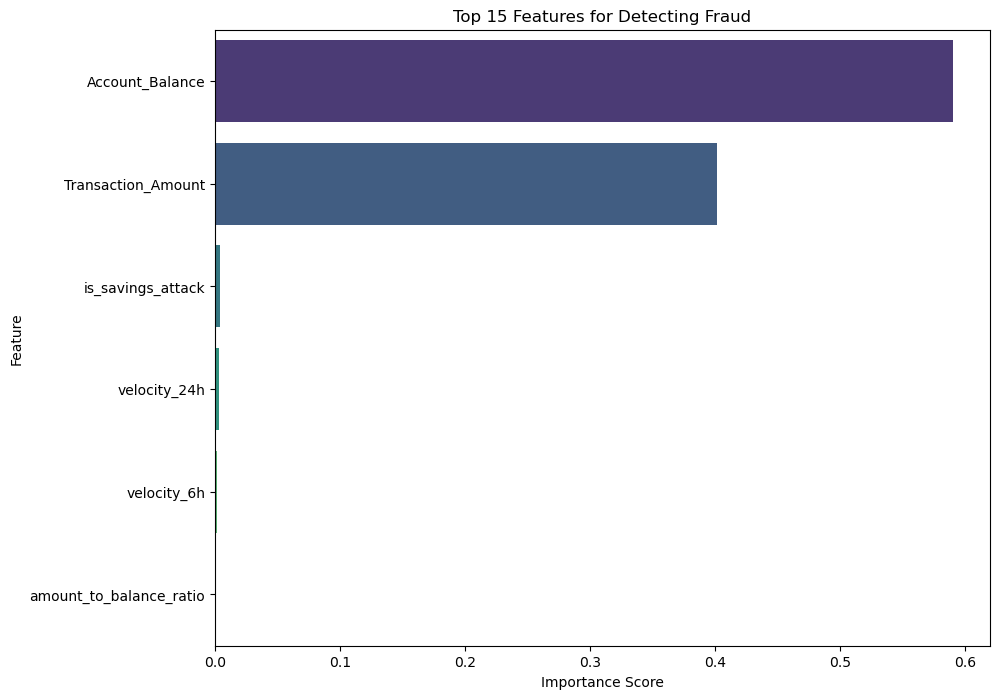

In [10]:
# 1. Get feature importances from your trained model
importances = rf.feature_importances_
feature_names = X.columns

# 2. Create a DataFrame for easy plotting
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 3. Plot only the Top 15 (otherwise it gets too crowded)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(25), palette='viridis')

plt.title('Top 15 Features for Detecting Fraud')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()